In [1]:
from music21 import *
import random, glob

In [2]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path="dataset"
files = [a for a in glob.glob("dataset/*/*")]
files = [a for a in glob.glob("dataset/tschai/*")]

#read all the filenames
#files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(i) for i in files])

Loading Music File: dataset/tschai\ty_april.mid
Loading Music File: dataset/tschai\ty_august.mid
Loading Music File: dataset/tschai\ty_dezember.mid
Loading Music File: dataset/tschai\ty_februar.mid
Loading Music File: dataset/tschai\ty_januar.mid
Loading Music File: dataset/tschai\ty_juli.mid
Loading Music File: dataset/tschai\ty_juni.mid
Loading Music File: dataset/tschai\ty_maerz.mid
Loading Music File: dataset/tschai\ty_mai.mid
Loading Music File: dataset/tschai\ty_november.mid
Loading Music File: dataset/tschai\ty_oktober.mid
Loading Music File: dataset/tschai\ty_september.mid


C:\Users\Dell\AppData\Local\Temp\ipykernel_7052\2431627556.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi(i) for i in files])


In [4]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

243


(array([158.,  28.,  14.,  10.,   8.,   6.,   6.,   7.,   2.,   4.]),
 array([  1. ,  33.7,  66.4,  99.1, 131.8, 164.5, 197.2, 229.9, 262.6,
        295.3, 328. ]),
 <BarContainer object of 10 artists>)

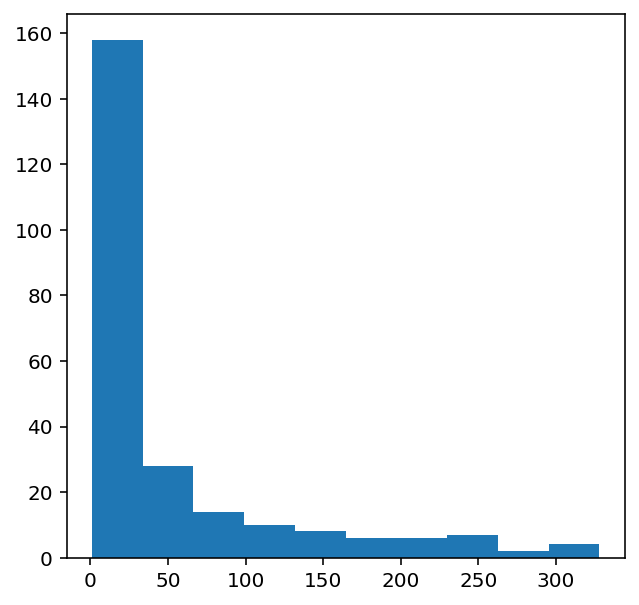

In [5]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [6]:
#keeping th higher frequncy only. more than 50 for now
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

64


In [7]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

C:\Users\Dell\AppData\Local\Temp\ipykernel_7052\2871568428.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


In [8]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [9]:
#assigning unique integer to every notes
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [10]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [11]:
# prepare the integer sequences for output data as well

unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [12]:
# preserving 80% of the data for training and the rest 20% for the evaluation:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [13]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [14]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           6400      
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [15]:
!pip install h5py


In [16]:
import h5py

In [17]:
#defining call back to save the best model during training>
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [18]:
# actual training starting
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, 
                    validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 4.0477
Epoch 00001: val_loss improved from inf to 3.99623, saving model to best_model.h5
59/59 [==============================] - 4s 53ms/step - loss: 4.0477 - val_loss: 3.9962
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 3.9070
Epoch 00002: val_loss improved from 3.99623 to 3.86979, saving model to best_model.h5
59/59 [==============================] - 3s 52ms/step - loss: 3.9064 - val_loss: 3.8698
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 3.6763
Epoch 00003: val_loss improved from 3.86979 to 3.63825, saving model to best_model.h5
59/59 [==============================] - 3s 50ms/step - loss: 3.6778 - val_loss: 3.6383
Epoch 4/50
58/59 [============================>.] - ETA: 0s - loss: 3.5066
Epoch 00004: val_loss improved from 3.63825 to 3.55562, saving model to best_model.h5
59/59 [==============================] - 3s 52ms/step - loss: 3.5069 - val_loss: 3.5556
Epoch 5/

Epoch 35/50
58/59 [============================>.] - ETA: 0s - loss: 1.9132
Epoch 00035: val_loss did not improve from 2.80230
59/59 [==============================] - 3s 59ms/step - loss: 1.9159 - val_loss: 2.8093
Epoch 36/50
58/59 [============================>.] - ETA: 0s - loss: 1.8778
Epoch 00036: val_loss improved from 2.80230 to 2.78837, saving model to best_model.h5
59/59 [==============================] - 4s 63ms/step - loss: 1.8761 - val_loss: 2.7884
Epoch 37/50
58/59 [============================>.] - ETA: 0s - loss: 1.8639
Epoch 00037: val_loss improved from 2.78837 to 2.76618, saving model to best_model.h5
59/59 [==============================] - 4s 65ms/step - loss: 1.8622 - val_loss: 2.7662
Epoch 38/50
59/59 [==============================] - ETA: 0s - loss: 1.8523
Epoch 00038: val_loss did not improve from 2.76618
59/59 [==============================] - 4s 66ms/step - loss: 1.8523 - val_loss: 2.7780
Epoch 39/50
59/59 [==============================] - ETA: 0s - loss: 1

In [20]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [37]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]
random_music

array([15, 23,  6, 53,  6, 31,  3, 16, 14, 17,  6, 53,  5, 32,  0, 17, 31,
        3, 16, 14, 17,  6, 53,  5, 32,  0, 17, 31,  3, 16,  0, 26])

In [38]:


predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[38, 53, 55, 53, 36, 36, 36, 17, 0, 17]


In [39]:
#intergers back to notes
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [40]:
# notes to midi format:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [41]:
midi_converted = convert_to_midi(predicted_notes)

In [42]:
from music21 import midi
def play_midi_file(midi_file_name):
    mf = midi.MidiFile()

    mf.open(midi_file_name) # path='abc.midi'
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [43]:
play_midi_file("music.mid")